In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from db import get_session

In [11]:
db = get_session()
df = pd.read_sql_table('activities', db.get_bind())

In [12]:
from src.vdot import user_VDOT

In [13]:
df['vdot'] = df.apply(lambda row: user_VDOT(row['distance'] / 1.01, 'meters', row['elapsed_time'] / 60.), axis=1)

In [14]:
df[['id', 'vdot']].sort_values(by='vdot', ascending=False).head(10)

,id,vdot
941,10953235861,60.001967
884,10633812362,59.132547
829,10357480869,58.775989
593,8511208212,58.719264
762,9971090272,57.805868
609,8614396249,56.358998
579,8427818299,55.274800
746,9803600648,53.547831
933,10916100958,51.500429
401,6982070799,51.397551


In [54]:
from src.vdot import percent_vo2max_to_percent_hrr, percent_hrr_to_percent_vo2max

FCM = 192 - 0.007 * 28 ** 2
FCR = 44

df['hr_adjusted_vdot'] = df.apply(lambda row: row['vdot'] * 100 / percent_hrr_to_percent_vo2max((row['average_heart_rate'] - FCR) / (FCM - FCR) * 100) , axis=1)

In [55]:
df[['id', 'vdot', 'hr_adjusted_vdot']].sort_values(by='hr_adjusted_vdot', ascending=False).head(10)

,id,vdot,hr_adjusted_vdot
978,11117427320,41.696389,70.062930
1044,11407758048,46.660036,69.627410
829,10357480869,58.775989,68.530084
715,9554500309,45.257216,68.298574
991,11159467295,43.993465,67.929357
746,9803600648,53.547831,67.768608
411,7058610723,48.863787,66.923137
415,7093278886,48.763020,66.785128
361,6724110729,42.051250,66.470182
475,7571368076,47.530970,66.463343


In [56]:
df.iloc[0].vdot / percent_hrr_to_percent_vo2max((df.iloc[0]['average_heart_rate'] - FCR) / (FCM - FCR) * 100) * 100

26.44875803381498

In [57]:
df.head(1)

,id,user_id,elapsed_time,moving_time,distance,elevation_gain,elevation_loss,average_pace,average_moving_pace,average_cadence,average_heart_rate,max_heart_rate,average_stride_length,average_temperature,calories,vdot,hr_adjusted_vdot
0,3458921386,1,1892,1856.0,4000,30.0,34.0,404,397.0,161.0,160.0,177.0,91.7405,NaN,423,21.493854,26.448758


In [58]:
percent_vo2max_to_percent_hrr((df.iloc[0]['average_heart_rate'] - FCR) / (FCM - FCR) * 100)

81.51885343014918

In [59]:
FCM

186.512

In [44]:
import numpy as np
import pandas as pd

from src.utils import num_time_to_str_time

vdot = 60

df = pd.read_csv('data/interim/vdot-to-race-paces-coefficients.csv')
df = df.reset_index()
df['Distance'] = [42195, 21097, 15000, 10000, 5000, 3200, 3000, 1600, 1500][::-1]
df = df.set_index('Distance')
df['Time'] = df.Coef1 * vdot + df.Coef2 * vdot ** 2 + df.Coef3 * vdot ** 3 + df.Coef4 * vdot ** 4 + df.Intercept

df = df.sort_values(by='Time', ascending=False)

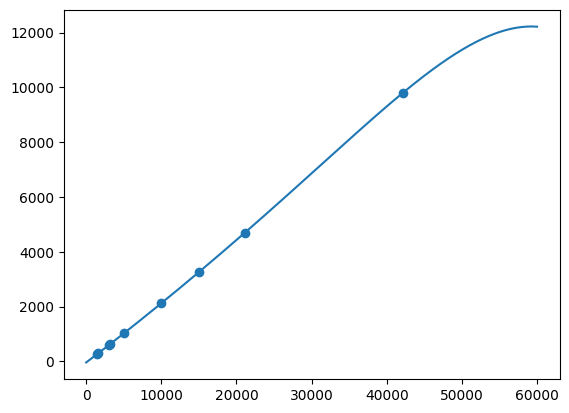

In [80]:
import matplotlib.pyplot as plt

coefficients = np.polyfit(df.index, df['Time'], 5)
poly_function = np.poly1d(coefficients)

plt.scatter(df.index, df['Time'])

poly_data = poly_function(range(60000))
plt.plot(range(60000), poly_data)

In [81]:
coefficients

array([-1.50445974e-20,  1.11829466e-15, -3.31645603e-11,  1.17199341e-06,
        2.06653860e-01, -3.68550687e+01])

In [82]:
num_time_to_str_time(poly_function(100000))

'2:47'

In [50]:
df['TimeStr'] = df.Time.apply(num_time_to_str_time)

In [130]:
df = df.reset_index()
df['Pace'] = df['Time'] / 60. / (df['Distance'] / 1000)

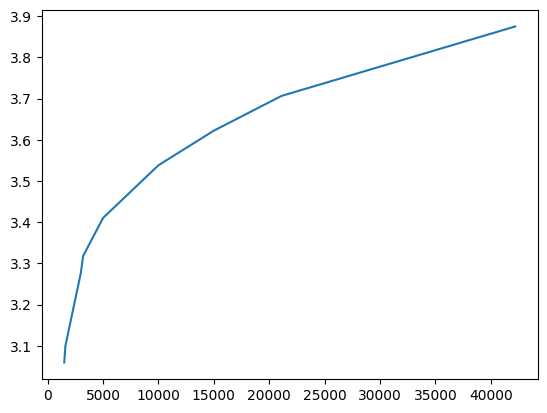

In [131]:
plt.plot(df.Distance, df.Pace)

Text(0, 0.5, 'y')

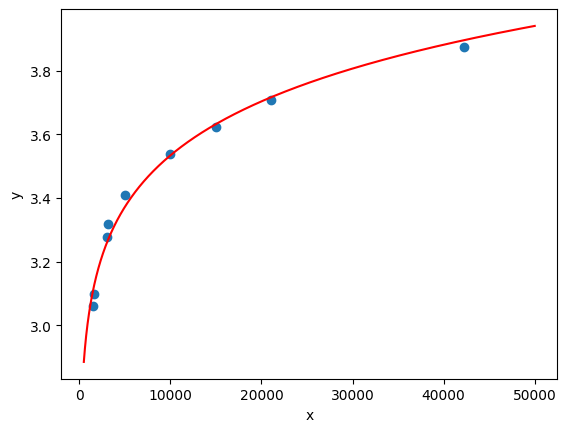

In [132]:
from scipy.optimize import curve_fit

x = df.Distance
y = df.Pace

# Transform the data by taking the logarithm
log_x = np.log(x)
log_y = np.log(y)

# Fit a linear polynomial to the transformed data
degree = 1  # Linear polynomial
coefficients = np.polyfit(log_x, log_y, degree)

# Calculate the coefficients for the original equation
a = np.exp(coefficients[1])
b = coefficients[0]

# Create the fitted logarithmic function
def logarithmic_fit(x):
    return a * np.exp(b * x)

# Plot the original data and the fitted curve
plt.scatter(x, y, label='Original Data')
plt.plot(range(500, 50000), logarithmic_fit(np.log(range(500, 50000))), color='red', label='Logarithmic Fit')
plt.xlabel('x')
plt.ylabel('y')

In [133]:
def logarithmic_function(x, a, b):
    return a + b * np.log(x)
# Fit the curve
initial_guess = (1, 1)  # Initial parameter guess
params, covariance = curve_fit(logarithmic_function, x, y, p0=initial_guess)


In [134]:

# Extract the fitted parameters
a2, b2 = params

# Create the fitted logarithmic function
def fitted_logarithmic(x):
    return a2 + b2 * np.log(x)

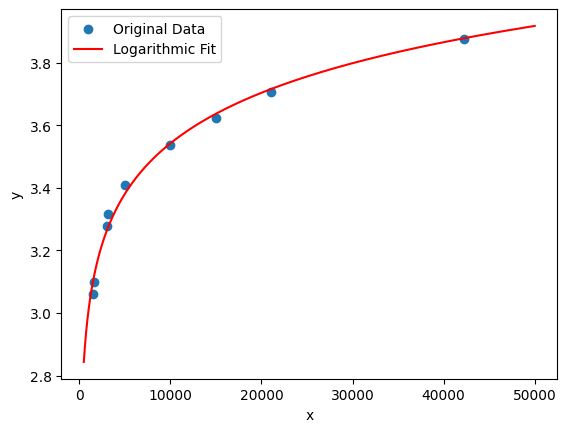

In [135]:
# Plot the original data and the fitted curve
plt.scatter(x, y, label='Original Data')
plt.plot(range(500, 50000), fitted_logarithmic(range(500, 50000)), color='red', label='Logarithmic Fit')
# plt.plot(range(500, 50000), logarithmic_fit(np.log(range(500, 50000))), color='red', label='Logarithmic Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

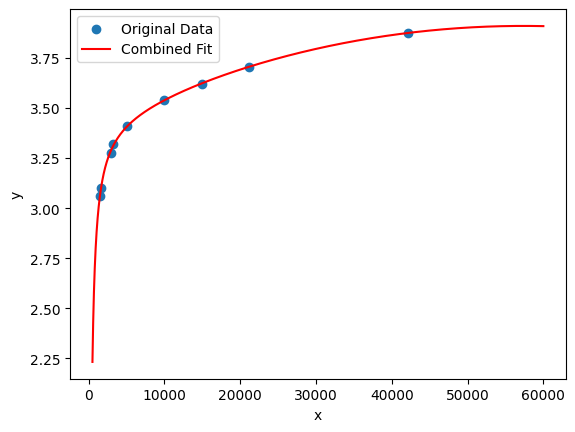

In [152]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Combined function with logarithmic and quadratic polynomial terms
def combined_function(x, a, b, c, d):
    return -a / x + b * x + c * x**2 + d

# Fit the combined curve
initial_guess = (1, 1, 1, 1)  # Initial parameter guess
params, covariance = curve_fit(combined_function, x, y, p0=initial_guess)

# Extract the fitted parameters
a, b, c, d = params

# Create the fitted combined function
def fitted_combined(x):
    x = np.array(x)
    # return a * np.log(b * x) + c * x**2 + d
    return -a / x + b * x + c * x**2 + d

# Plot the original data and the fitted curve
plt.scatter(x, y, label='Original Data')
plt.plot(range(500, 60000), fitted_combined(range(500, 60000)), color='red', label='Combined Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


In [156]:
(fitted_combined(800) * 0.8 - 2) * 60

9.41839853546611

In [129]:
df

,Distance,index,Intercept,Coef1,Coef2,Coef3,Coef4,Time,TimeStr,Pace
0,42195,8,42412.877898,-1385.211599,23.849224,-0.205855,0.000704,9810.666572,2:43:31,0.232508
1,21097,7,21385.425813,-719.086428,12.517606,-0.108409,0.000371,4691.775313,118:12,0.222391
2,15000,6,15096.287182,-514.951211,9.052592,-0.078876,0.000271,3260.065141,54:20,0.217338
3,10000,5,9846.377922,-338.195784,5.986958,-0.052430,0.000181,2123.008249,35:23,0.212301
4,5000,4,4684.934538,-159.353411,2.808627,-0.024584,0.000085,1023.131492,17:03,0.204626
5,3200,3,2961.047490,-100.512960,1.755688,-0.015219,0.000052,637.047556,10:37,0.199077
6,3000,2,2754.111947,-93.546699,1.632166,-0.014130,0.000048,590.002362,9:50,0.196667
7,1600,1,1477.272197,-52.472555,0.942520,-0.008325,0.000029,297.552250,4:58,0.185970
8,1500,0,1361.928267,-48.170940,0.861648,-0.007580,0.000026,275.374691,4:35,0.183583
